## Teoría Moderna de Markowitz

- Simulación Monte-Carlo.
- Optimización sujeta a restricciones.
- Optimización usando algoritmos genéticos.

En la siguiente [libreta](https://github.com/ZesarGal/Python-for-finance-/blob/main/Markowitz_01.ipynb), puedes encontrar gráficos iteractivos usando la librería `plotly.express`

**Describir el modelo de optimización de Markowitz en la teoría moderna de portafolios**.

In [1]:
!pip install yahoo_fin
!pip install yahoo_fin --upgrade
!pip install pandas_datareader

import yahoo_fin as yfin
import yahoo_fin.stock_info as si
import pandas as pd
import numpy as np
from datetime import datetime
import statistics
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pandas_datareader import data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 3.1 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6049 sha256=92898b08a72e0f586608566abe90269e0d7e61b28b242f2d70b7565dbe94553d
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7


In [2]:
#en esta parte se extraen de yahoo finance (importado arriba) los datos históricos
#de las acciones que van a conformar el portafolio

IBM_s_t = si.get_data("IBM", start_date = "11/28/2018", end_date = "11/28/2023")
AMZN_s_t = si.get_data("AMZN", start_date = "11/28/2018", end_date = "11/28/2023")
AAPL_s_t = si.get_data("AAPL", start_date = "11/28/2018", end_date = "11/28/2023")
MSFT_s_t = si.get_data("MSFT", start_date = "11/28/2018", end_date = "11/28/2023")
TSLA_s_t = si.get_data("TSLA", start_date = "11/28/2018", end_date = "11/28/2023")
ORCL_s_t = si.get_data("ORCL", start_date = "11/28/2018", end_date = "11/28/2023")
JNJ_s_t = si.get_data("JNJ", start_date = "11/28/2018", end_date = "11/28/2023")
GM_s_t = si.get_data("GM", start_date = "11/28/2018", end_date = "11/28/2023")
BABA_s_t = si.get_data("BABA", start_date = "11/28/2018", end_date = "11/28/2023")

In [3]:
#Con los datos, nos fijamos en los precios con los que cerró cada acción y
#los ponemos en una tabla dependiendo la fecha
portafolio = pd.concat([IBM_s_t["adjclose"],AMZN_s_t["adjclose"],AAPL_s_t["adjclose"],MSFT_s_t["adjclose"],TSLA_s_t["adjclose"],ORCL_s_t["adjclose"],JNJ_s_t["adjclose"],GM_s_t["adjclose"],BABA_s_t["adjclose"]], axis=1)
portafolio.columns = ["IBM","AMZN","AAPL","MSFT","TSLA","ORCL","JNJ","GM","BABA"]
portafolio.head()

,IBM,AMZN,AAPL,MSFT,TSLA,ORCL,JNJ,GM,BABA
2018-11-28,90.407814,83.887497,43.302982,105.134827,23.191334,44.085964,125.921791,34.044514,157.226456
2018-11-29,89.290581,83.678497,42.970333,104.254913,22.744667,43.820660,125.414452,33.869453,154.207047
2018-11-30,91.341301,84.508499,42.738182,104.917206,23.365334,44.607426,126.317329,34.965885,158.726303
2018-12-03,92.105698,88.617996,44.231552,106.052582,23.899332,45.586288,125.724022,35.426571,161.568100
2018-12-04,89.378777,83.419998,42.285851,102.674858,23.980000,44.598270,125.569229,33.648335,156.239716


<Axes: >

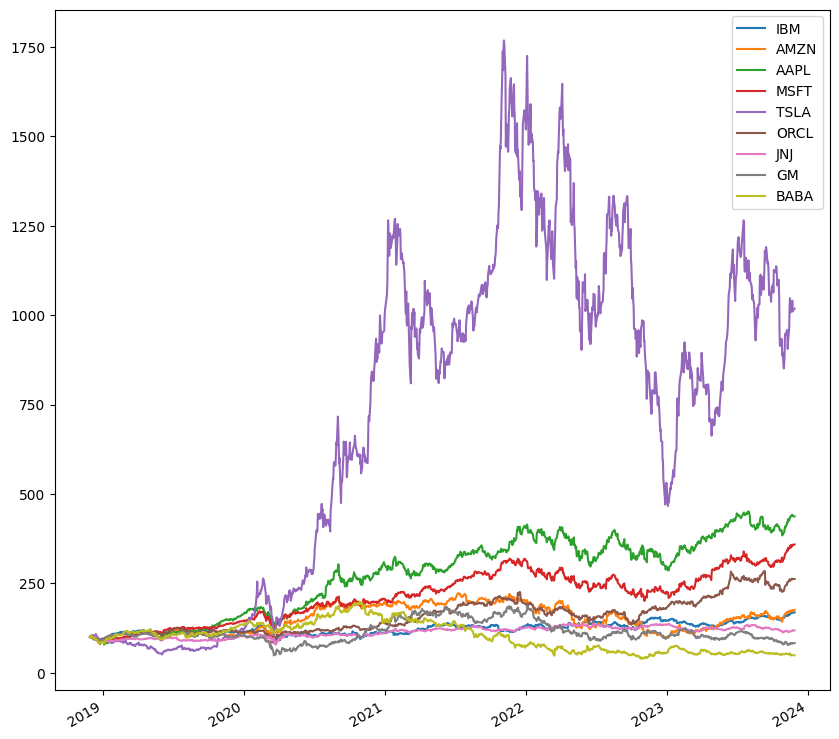

In [5]:
#Gracicamos los valores de la tablita denuevo dependiendo el año y en forma de porcentajes
(portafolio/portafolio.iloc[0]*100).plot(figsize=(10,10))

In [6]:
#Lista con el nombre de las empresas que conforman el portafolio
list_portafolio = ["IBM","AMZN","AAPL","MSFT","TSLA","ORCL","JNJ","GM","BABA"]

In [7]:
#función para calcular los retornos por acción
def calcular_retornos(portafolio):
    return portafolio.pct_change()

In [8]:
retornos = calcular_retornos(portafolio)
retornos.dropna()
retornos.sum()

IBM     0.700022
AMZN    0.887528
AAPL    1.741913
MSFT    1.516144
TSLA    3.378591
ORCL    1.193576
JNJ     0.272882
GM      0.258662
BABA   -0.144784
dtype: float64

In [9]:
#realizamos una tabla con los retornos que calculamos
retornos

,IBM,AMZN,AAPL,MSFT,TSLA,ORCL,JNJ,GM,BABA
2018-11-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-29,-0.012358,-0.002491,-0.007682,-0.008369,-0.019260,-0.006018,-0.004029,-0.005142,-0.019204
2018-11-30,0.022967,0.009919,-0.005403,0.006353,0.027288,0.017954,0.007199,0.032372,0.029306
2018-12-03,0.008369,0.048628,0.034942,0.010822,0.022854,0.021944,-0.004697,0.013175,0.017904
2018-12-04,-0.029606,-0.058656,-0.043989,-0.031850,0.003375,-0.021674,-0.001231,-0.050195,-0.032979
...,...,...,...,...,...,...,...,...,...
2023-11-20,0.009549,0.006544,0.009278,0.020522,0.005548,0.013523,0.008816,0.017481,0.011083
2023-11-21,-0.002851,-0.015260,-0.004231,-0.011578,0.023769,-0.007184,0.008071,-0.021739,0.006118
2023-11-22,0.007927,0.019528,0.003514,0.012813,-0.028980,0.001378,-0.001985,0.007169,0.000253
2023-11-24,0.000322,0.000204,-0.007004,-0.001112,0.005294,0.000086,0.011139,0.002847,-0.005952


In [10]:
#.shift es una función que permite desplazar o retrasar los valores en un
#DataFrame a lo largo del eje especificado.
def retornos_log(portafolio):
  return np.log(portafolio) - np.log(portafolio.shift(1))

In [11]:
log_retornos = retornos_log(portafolio)
log_retornos = log_retornos.dropna()
log_retornos.sum()

IBM     0.523812
AMZN    0.565910
AAPL    1.475066
MSFT    1.277613
TSLA    2.320392
ORCL    0.964403
JNJ     0.167856
GM     -0.183575
BABA   -0.720375
dtype: float64

In [12]:
#Promediamos los retornos
log_retornos

,IBM,AMZN,AAPL,MSFT,TSLA,ORCL,JNJ,GM,BABA
2018-11-29,-0.012435,-0.002495,-0.007712,-0.008405,-0.019448,-0.006036,-0.004037,-0.005155,-0.019391
2018-11-30,0.022707,0.009870,-0.005417,0.006333,0.026923,0.017795,0.007173,0.031859,0.028885
2018-12-03,0.008334,0.047483,0.034346,0.010764,0.022597,0.021707,-0.004708,0.013089,0.017745
2018-12-04,-0.030054,-0.060447,-0.044986,-0.032368,0.003370,-0.021912,-0.001232,-0.051499,-0.033535
2018-12-06,0.018819,0.018287,-0.011212,0.006155,0.009298,-0.043389,-0.000822,-0.012250,-0.015979
...,...,...,...,...,...,...,...,...,...
2023-11-20,0.009504,0.006522,0.009235,0.020314,0.005533,0.013432,0.008777,0.017330,0.011022
2023-11-21,-0.002855,-0.015378,-0.004240,-0.011646,0.023491,-0.007210,0.008039,-0.021979,0.006099
2023-11-22,0.007895,0.019339,0.003508,0.012731,-0.029408,0.001377,-0.001987,0.007143,0.000253
2023-11-24,0.000322,0.000204,-0.007029,-0.001112,0.005280,0.000086,0.011077,0.002843,-0.005970


<Axes: >

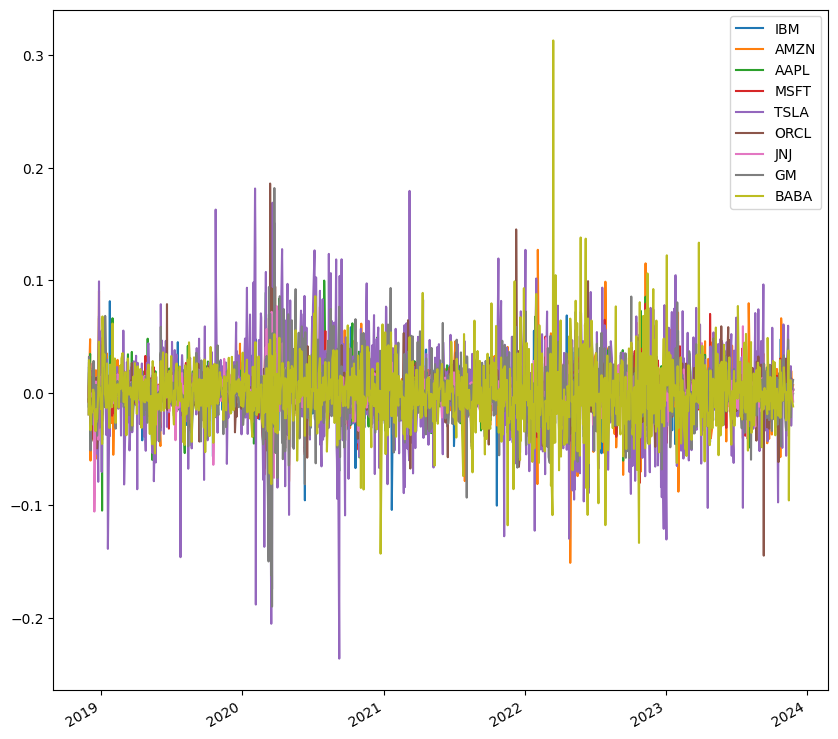

In [13]:
log_retornos.plot(figsize=(10,10))

In [14]:
#asignamos pesos de manera aleatoria
num_stocks = len(list_portafolio)
random_array = np.random.random(num_stocks)

In [15]:
#La suma de los pesos debe dar 1
pesos = np.random.random(num_stocks)
pesos /= np.sum(pesos)

In [16]:
pesos

array([0.06589086, 0.11988349, 0.1492193 , 0.12667125, 0.09747545,
       0.1303992 , 0.13284406, 0.05197326, 0.12564314])

In [17]:
#Calculamos el retorno con los pesos asignados y lo calculamos para 250 sesiones en un año
np.sum(pesos*log_retornos.mean())*250

0.1509731255445529

In [18]:
#Calculamos la varianza del retorno usando el producto punto
varianza = np.dot(pesos.T,np.dot(log_retornos.cov()*250,pesos))


In [19]:
#La raíz de la varianza es la volatilidad y esto nos deja ver que tan riesgosa es la acción
volatilidad = np.sqrt(varianza)
volatilidad

0.24786928066214428

In [20]:
#SIMULACIONES

retornos_portafolio = []
volatilidades_portafolio = []
for x in range (1000):
  pesos = np.random.random(num_stocks)
  pesos /= np.sum(pesos)
  retornos_portafolio.append(np.sum(pesos*log_retornos.mean())*250)
  volatilidades_portafolio.append(np.sqrt(np.dot(pesos.T,np.dot(log_retornos.cov()*250,pesos))))

In [21]:
retornos_portafolio = np.array(retornos_portafolio)
volatilidades_portafolio = np.array(volatilidades_portafolio)
portafolios2 = pd.DataFrame({"Retorno":retornos_portafolio,"Volatilidad":volatilidades_portafolio})
portafolios2.tail()

,Retorno,Volatilidad
995,0.208180,0.288598
996,0.090215,0.226090
997,0.141705,0.236307
998,0.186599,0.261575
999,0.139590,0.232598


Text(0, 0.5, 'Retorno')

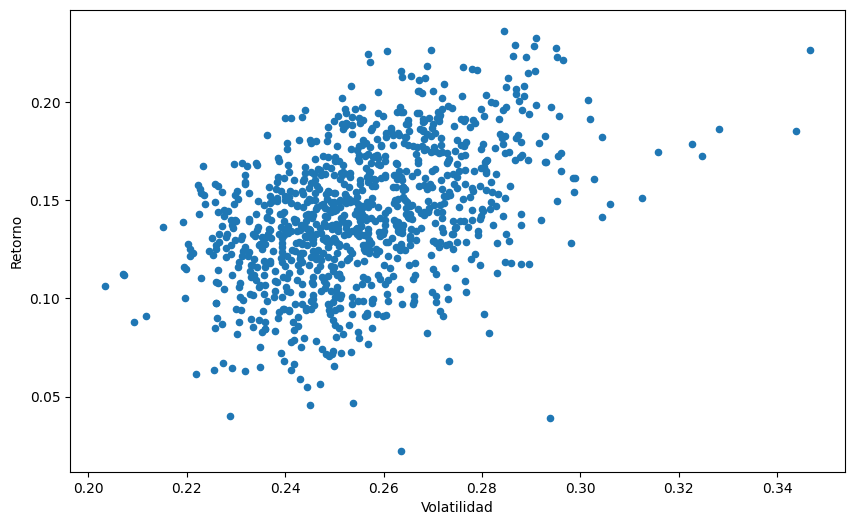

In [23]:
#Grafico de la frontera eficiente
#Comparamos el riesgo contra la ganancia que generan

portafolios2.plot(x="Volatilidad",y="Retorno",kind="scatter",figsize=(10,6))
plt.xlabel("Volatilidad")
plt.ylabel("Retorno")

In [24]:
#Calculamos los retornos esperados

RetornosE = pd.DataFrame(log_retornos.mean()) #obtenemos el promedio de cada acción
RetornosE

,0
IBM,0.000417
AMZN,0.000451
AAPL,0.001174
MSFT,0.001017
TSLA,0.001847
ORCL,0.000768
JNJ,0.000134
GM,-0.000146
BABA,-0.000574


In [25]:
#Calculamos el riesgo individual por cada acción y para eso obtenemos la desviación estándar por acción

RiesgoI = pd.DataFrame(log_retornos.std())
RiesgoI

,0
IBM,0.016781
AMZN,0.022634
AAPL,0.020590
MSFT,0.019473
TSLA,0.041037
ORCL,0.019053
JNJ,0.012946
GM,0.026573
BABA,0.030126


In [26]:
#Realizamos la matriz de varianza y covarianza

datacov = log_retornos.select_dtypes(include=["float64","int"])
corr_matrix = datacov.corr(method="pearson")
corr_matrix

,IBM,AMZN,AAPL,MSFT,TSLA,ORCL,JNJ,GM,BABA
IBM,1.000000,0.299769,0.449282,0.455850,0.206164,0.497549,0.485668,0.473621,0.204649
AMZN,0.299769,1.000000,0.631653,0.691038,0.442187,0.413914,0.245076,0.322928,0.361822
AAPL,0.449282,0.631653,1.000000,0.765466,0.497747,0.526108,0.409782,0.429307,0.379628
MSFT,0.455850,0.691038,0.765466,1.000000,0.466137,0.587777,0.425739,0.422988,0.352723
TSLA,0.206164,0.442187,0.497747,0.466137,1.000000,0.244354,0.122684,0.377731,0.325805
ORCL,0.497549,0.413914,0.526108,0.587777,0.244354,1.000000,0.409268,0.404700,0.260783
JNJ,0.485668,0.245076,0.409782,0.425739,0.122684,0.409268,1.000000,0.258216,0.139443
GM,0.473621,0.322928,0.429307,0.422988,0.377731,0.404700,0.258216,1.000000,0.316858
BABA,0.204649,0.361822,0.379628,0.352723,0.325805,0.260783,0.139443,0.316858,1.000000


In [27]:
#CALCULAMOS EL RENDIMIENTO ESPERADO DEL PORTAFOLIO

pesos = np.random.random(9) #Asignamos pesos aleatorios a cada acción
pesos /= np.sum(pesos)
pesos

array([0.15116361, 0.13013961, 0.09247435, 0.11459178, 0.1021582 ,
       0.11886806, 0.11180293, 0.07192303, 0.10687842])

In [28]:
RetE = RetornosE.iloc[:, 0].values
print(RetE)

[ 0.00041705  0.00045057  0.00117442  0.00101721  0.00184745  0.00076784
  0.00013364 -0.00014616 -0.00057355]


In [29]:
np.matmul(pesos,RetE) #Rendimiento esperado del portafolio

0.0005699785798916827

In [30]:
#CALCULAMOS LA VARIANZA DEL PORTAFOLIO

transpesos = pesos.transpose()
SxW = np.dot(corr_matrix, transpesos)
VARP = np.matmul(pesos,SxW)
VARP

0.466986625981435

In [31]:
#CALCULAMOS EL RIESGO INDIVIDUAL DEL PORTAFOLIO
RIP = np.sqrt(VARP)
RIP

0.6833641971755873

**Da una breve descripción del uso de la librería**

`PyPortfolioOpt`

**y sus principales atributos**

PyPortfolioOpt es una biblioteca de Python que se usa para ayudar en la construcción y optimización de carteras de inversión. Sirve para:

1. Construir carteras: Proporciona herramientas para construir carteras de inversión utilizando diferentes técnicas.

2. Optimización de carteras: Ayuda a optimizar las carteras para maximizar el rendimiento esperado, minimizar el riesgo o alcanzar un equilibrio entre ambos, tomando en cuenta restricciones como límites de asignación, costos de transacción y restricciones de liquidez.

3. Análisis de riesgo: tiene herramientas para analizar el riesgo de las carteras, como la volatilidad, la matriz de covarianza y otras métricas de riesgo.

Sus principales atributos son:

1. Optimización de Markowitz: Esta teoría busca encontrar la combinación óptima de activos que maximice el rendimiento esperado para un nivel dado de riesgo.
2. Optimización de mínima varianza: Permite construir carteras que minimicen la varianza o la volatilidad, y es útil para inversores que buscan minimizar el riesgo.
3. Optimización de Sharpe ratio: Puede optimizar carteras para maximizar el índice de Sharpe, que es una medida de rendimiento ajustada al riesgo.
4. Modelos de riesgo personalizados: Permite a los usuarios definir y utilizar sus propios modelos de riesgo para adaptarse a las necesidades específicas de su cartera.
5. Interfaz fácil de usar: La biblioteca ofrece una interfaz fácil de usar con solo unas pocas líneas de código.

In [32]:
#INSTALAMOS LA PAQUETERÍA PyPortfolioOpt y las funciones para resolver problemas de frontera eficiente
!pip install PyPortfolioOpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 645.5 kB/s eta 0:00:00


In [33]:
from pypfopt.efficient_frontier import EfficientFrontier

In [34]:
#Usamos la función EfficientFrontier para calcular los portafolios óptimos, con la condición de que los pesos deben
#ser positivos
ef = EfficientFrontier(RetE,corr_matrix,weight_bounds=(0,1))
#Obtenemos los pesos que nos generen la mínima volatilidad
w = ef.min_volatility()
c_w = ef.clean_weights()
c_w

OrderedDict([('IBM', 0.09856),
             ('AMZN', 0.09636),
             ('AAPL', 0.0),
             ('MSFT', 0.0),
             ('TSLA', 0.19151),
             ('ORCL', 0.08677),
             ('JNJ', 0.22249),
             ('GM', 0.09974),
             ('BABA', 0.20457)])

## Algoritmos genéticos.

**Escribe, detalladamente, en qué consisten los algoritmos genéticos**

Puedes usar las siguientes referencias:

- https://www.javatpoint.com/genetic-algorithm-in-machine-learning

- https://www.mathworks.com/help/gads/how-the-genetic-algorithm-works.html

- https://www.spiceworks.com/tech/artificial-intelligence/articles/what-are-genetic-algorithms/

Los algoritmos genéticos son una técnica de optimización inspirada en la teoría de la evolución y la selección natural. Funcionan de manera similar a cómo opera la evolución en la naturaleza, donde las soluciones más fuertes para un problema dado tienen más probabilidades de sobrevivir y reproducirse, transmitiendo sus características a las generaciones futuras.

Población inicial:

Se comienza con una población inicial de soluciones posibles que se representan típicamente como cromosomas o genes, donde cada gen codifica una característica o parámetro de la solución.

Evaluación de la aptitud (fitness):

Cada individuo en la población inicial se evalúa utilizando una función de aptitud que mide qué tan buena es esa solución en términos de resolver el problema dado. La función de aptitud asigna un valor numérico a cada solución,los valores más altos son las soluciones más aptas.

Selección:

Se seleccionan individuos de la población actual para formar la próxima generación. La selección se realiza de manera probabilística, donde las mejores soluciones tienen mayor probabilidad de ser seleccionadas. Esto se hace simulando el proceso de selección natural, donde los individuos más aptos tienen una mayor probabilidad de reproducirse.

Cruce (crossover):

Las soluciones seleccionadss se cruzan entre sí para producir descendencia. Durante el cruce, se intercambian partes de los cromosomas entre los padres para crear nuevos individuos, combinando las características de ambos. Con esto ayudamos a explorar nuevas áreas del espacio de búsqueda de soluciones.

Mutación:

En algunos casos, se introduce aleatoriamente una pequeña cantidad de cambio en los individuos descendientes. Se conoce como mutación y ayuda a mantener la diversidad genética en la población, evitando la convergencia prematura hacia una solución sno tan óptima.

Repetición:

Los pasos de evaluación de aptitud, selección, cruce y mutación se repiten durante varias generaciones o iteraciones, con la esperanza de que la población evolucione hacia soluciones mejores.

Criterio de terminación:

El algoritmo continúa iterando hasta que se alcanza un criterio de terminación predefinido, como un número máximo de generaciones, una aptitud mínima alcanzada o un tiempo de cómputo agotado.
Los algoritmos genéticos son útiles para problemas de optimización en los que el espacio de búsqueda es grande y no se dispone de un método analítico directo para encontrar la solución óptima.
Se aplican en muchos campos, como la ingeniería, la economía, la biología computacional y el aprendizaje automático.

**Usando los mismos tickers de arriba, construye un algoritmo genético que optimice los pesos**


In [35]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

stocks = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'NVDA', 'JNJ', 'JPM', 'BAC', 'GS', 'MS']
start_date = '2010-01-01'
data = yf.download(stocks, start=start_date)['Adj Close']
benchmark = yf.download('^OEX', start=start_date)['Adj Close']

[*********************100%%**********************]  10 of 10 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: OperationalError('database is locked')
[*********************100%%**********************]  1 of 1 completed


**Función fitness**

In [36]:
def fitness_function(weights, data):
    data_returns = np.log(data) - np.log(data.shift(1))
    data_returns = data_returns.dropna()

    portfolio_returns = np.dot(data_returns, weights)
    portfolio_mean = np.mean(portfolio_returns)
    portfolio_std = np.std(portfolio_returns)
    sharpe_ratio = (portfolio_mean / portfolio_std) * np.sqrt(252)
    return sharpe_ratio

**Algoritmo genético**

In [37]:
def genetic_algorithm(data, population_size=200, num_generations=50, mutation_rate=0.05, elitism=0.1):
    population = np.random.rand(population_size, len(data.columns))
    population = population / np.sum(population, axis=1)[:, np.newaxis]


    fitness = np.array([fitness_function(individual, data) for individual in population])

    for generation in range(num_generations):
        sorted_idx = np.argsort(fitness)[::-1]
        population = population[sorted_idx]
        fitness = fitness[sorted_idx]


        num_elites = int(elitism * population_size)

        offspring = population[:num_elites]

        parent1_idx = np.random.randint(num_elites, population_size, size=population_size-num_elites)
        parent2_idx = np.random.randint(num_elites, population_size, size=population_size-num_elites)
        parent1 = population[parent1_idx]
        parent2 = population[parent2_idx]

        crossover_prob = np.random.rand(population_size-num_elites, len(data.columns))
        crossover_mask = crossover_prob <= 0.5
        offspring_crossover = np.where(crossover_mask, parent1, parent2)

        mutation_prob = np.random.rand(population_size-num_elites, len(data.columns))
        mutation_mask = mutation_prob <= mutation_rate
        mutation_values = np.random.rand(population_size-num_elites, len(data.columns))
        mutation_direction = np.random.choice([-1, 1], size=(population_size-num_elites, len(data.columns)))
        offspring_mutation = np.where(mutation_mask, offspring_crossover + mutation_direction * mutation_values, offspring_crossover)


        offspring_mutation = offspring_mutation / np.sum(offspring_mutation, axis=1)[:, np.newaxis]


        population = np.vstack((population[:num_elites], offspring_mutation))


        fitness = np.array([fitness_function(individual, data) for individual in population])


    best_idx = np.argmax(fitness)
    best_individual = population[best_idx]
    print('Best Sharpe Ratio: ', np.max(fitness))

    return best_individual

**Algoritmo**

In [38]:
from datetime import datetime, timedelta
import numpy as np

np.random.seed(42)

def backtest(genetic_algorithm, data, benchmark, initial_capital):

    train_data = data.iloc[:-252]
    test_data = data.iloc[-252:]

    weights = genetic_algorithm(data=train_data, population_size=100, num_generations=50, mutation_rate=0.01, elitism=0.01)

    weights[weights < 0] = 0

    weights /= weights.sum()

    portfolio_returns = np.dot(test_data.pct_change().dropna(), weights)
    portfolio_cum_returns = np.cumprod(1 + portfolio_returns)
    portfolio_value = initial_capital * portfolio_cum_returns[-1]
    benchmark_returns = benchmark.iloc[-252:].pct_change().dropna()
    benchmark_cum_returns = np.cumprod(1 + benchmark_returns)
    benchmark_value = initial_capital * benchmark_cum_returns[-1]


    portfolio_mean_return = np.mean(portfolio_returns)
    portfolio_std = np.std(portfolio_returns)
    portfolio_sharpe_ratio = (portfolio_mean_return / portfolio_std) * np.sqrt(252)
    benchmark_mean_return = np.mean(benchmark_returns)
    benchmark_std = np.std(benchmark_returns)
    benchmark_sharpe_ratio = (benchmark_mean_return / benchmark_std) * np.sqrt(252)

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(benchmark_cum_returns.index, portfolio_cum_returns, label='Portfolio')
    ax.plot(benchmark_cum_returns, label='Benchmark')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Returns')
    ax.set_title('Backtesting Results')
    ax.legend()
    plt.show()


    print('Estadísticas del portafolio:')
    print('---------------------')
    print('Rendimiento medio diario: {:.4f}'.format(portfolio_mean_return))
    print('Desviación estándar: {:.4f}'.format(portfolio_std))
    print('Índice de Sharpe: {:.4f}'.format(portfolio_sharpe_ratio))
    print('Valor final: {:.2f}'.format(portfolio_value))
    print('')
    print('Estadísticas del benchmark:')
    print('---------------------')
    print('Rendimiento medio diario: {:.4f}'.format(benchmark_mean_return))
    print('Desviación estándar: {:.4f}'.format(benchmark_std))
    print('Índice de Sharpe: {:.4f}'.format(benchmark_sharpe_ratio))
    print('Valor final: {:.2f}'.format(benchmark_value))

    return portfolio_returns, benchmark_returns, portfolio_cum_returns, benchmark_cum_returns

portfolio_returns, benchmark_returns, portfolio_cum_returns, benchmark_cum_returns = backtest(genetic_algorithm, data, benchmark, initial_capital=1000)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Best Sharpe Ratio:  nan


IndexError: index -1 is out of bounds for axis 0 with size 0